In [50]:

# Install required libraries
# Import required libraries
import random
import math
import gymnasium as gym
from gymnasium import spaces
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import namedtuple, deque
from itertools import count
import tensorflow as tf
import keras
import os
# print("Num CPUs Available: ", tf.config.experimental.list_physical_devices('CPU'))

# device = torch.device(
#     "cuda" if torch.cuda.is_available() else
#     "cpu"
# )

# print(device)
# CUDA_LAUNCH_BLOCKING=1

In [51]:
def DQN(obs, actions):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=obs, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(actions, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae']) #auto learning rate
    return model

class Agent:
    def __init__(self, obs, actions):

        self.actions = actions
        self.discount_factor = 0.99 #gamma
        self.epsilon = 1
        self.epsilon_decay = 0.9954
        self.epsilon_min = 0.01
        self.batch_size = 128
        self.size = 5000
        self.state_mem = np.zeros((self.size,obs))
        self.next_state_mem = np.zeros((self.size,obs))
        self.action_mem = np.zeros(self.size, dtype = int )
        self.reward_mem = np.zeros(self.size)
        self.done_mem = np.zeros(self.size,dtype=np.float32)
        self.pointer = 0
        self.policy_net = DQN(obs, actions)
        self.target_net = DQN(obs, actions) 

    def append(self, state, action, reward, next_state, done):
        i = self.pointer % self.size #get index
        self.state_mem[i] = state
        self.next_state_mem[i] = next_state
        self.reward_mem[i] = reward 
        self.done_mem[i] = done
        self.action_mem[i] = action
        self.pointer +=1

    def sample(self,batch):
        mem = min(self.pointer,self.size) # get range to choose mem from
        batch = np.random.choice(mem,batch) # choose random indices
        states = self.state_mem[batch]
        next_states = self.next_state_mem[batch]
        actions = self.action_mem[batch]
        rewards = self.reward_mem[batch]
        done = self.done_mem[batch]
        return states, actions, rewards, next_states, done
    
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.actions)  # random action
        state = state[np.newaxis,:]
        q_values = self.policy_net.predict(state, verbose=0)
        return np.argmax(q_values)  # best action

    def replay(self):
        if self.pointer < self.batch_size:
            return
        # print("learn god damn it")
        state, action, reward, next_state, done = self.sample(self.batch_size)

        # estimate cuurent q values
        q_eval = self.policy_net.predict(state,verbose = 0)
        # set target values
        q_next = self.target_net.predict(next_state, verbose = 0)
        q_target = q_eval.copy()
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        # print('batch',batch_index)
        # print(action)
        q_target[batch_index,action] = reward + self.discount_factor *np.max(q_next,axis=1) *done

        self.policy_net.fit(state, q_target, verbose=0,)
        return
        


Episode: 0, total: -0.6604337692260742
Episode: 1, total: -0.580452024936676


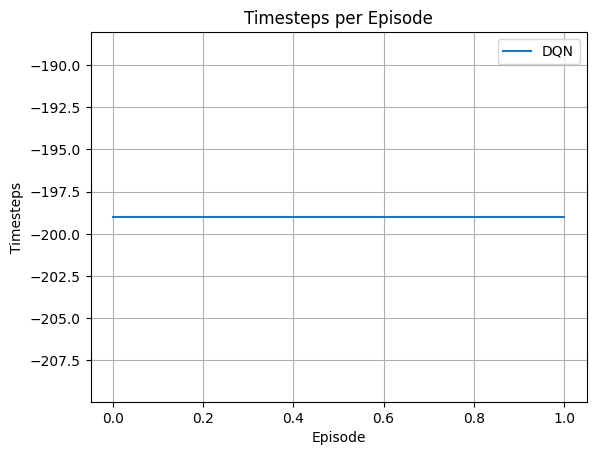

Episode: 2, total: -0.12183402478694916
Episode: 3, total: -0.4753454625606537
Episode: 4, total: -0.26463526487350464
Episode: 5, total: -0.44953078031539917
Episode: 6, total: -1.200749158859253
Episode: 7, total: -0.4703279435634613
Episode: 8, total: -0.49887603521347046
Episode: 9, total: -0.5437251329421997
Episode: 10, total: -1.0497184991836548
Episode: 11, total: -0.6158492565155029
Episode: 12, total: -0.3420639932155609
Episode: 13, total: -0.6374503374099731
Episode: 14, total: -0.3599952757358551
Episode: 15, total: -0.307817280292511
Episode: 16, total: -0.08799178153276443
Episode: 17, total: -0.2943744361400604
Episode: 18, total: -0.17908456921577454
Episode: 19, total: -0.0341731421649456
Episode: 20, total: -0.16932666301727295
Episode: 21, total: -0.32057008147239685
Episode: 22, total: -0.32568129897117615
Episode: 23, total: -0.5931057929992676
Episode: 24, total: -0.6214487552642822
Episode: 25, total: -0.10865528136491776
Episode: 26, total: -0.3981119990348816


KeyboardInterrupt: 

In [ ]:

if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    obs = env.observation_space.shape[0]
    actions = env.action_space.n
    agent = Agent(obs, actions)
    max_episodes = 2000
    reward_per_episode = []

    for episode in range(max_episodes):
        state, info = env.reset()
        
        terminated,truncated = False,False
        if episode % 5 == 0:
            agent.target_net.set_weights(agent.policy_net.get_weights())
        total = 0
        for timestep in range(500):
            action = agent.select_action(state)
            # print('action:', action)
            # state = np.reshape(state,(1,2))
            next_state, reward, terminated, truncated, _ = env.step(action)
            result = terminated or truncated
            # reward = 100*((math.sin(3*next_state[0,0]) * 0.0025+0.5*next_state[0,1] * next_state[0,1] - (math.sin(3*state[0,0]) * 0.0025+0.5* state[0,1] * state[0,1])))
            reward = 100*((math.sin(3*next_state[0,0])*0.0025+0.05*next_state[1]*next_state[1])-(math.sin(3*state[0,0])*0.0025+0.5*state[0,1]*state[0,1]))
            total += reward
            if result == True:
                done = 0
            else:
                done = 1
            agent.append(state=state, action=action, reward=reward, next_state=next_state, done=done)
            state = next_state
            if timestep %5 == 0 :
                agent.replay()  # Update network weights
            if result == True:
                reward_per_episode.append(-timestep)
                print(f'Episode: {episode}, total: {total}')
                break
        if episode % 100 == True:
            plt.figure()
            plt.plot(reward_per_episode, label='DQN')
            plt.xlabel('Episode')
            plt.ylabel('Timesteps')
            plt.title('Timesteps per Episode')
            plt.legend()
            plt.grid()
            plt.show()
            # print("saved_weights")
            a= agent.policy_net.get_weights()
            with open('mountain.pickle', 'wb') as handle:
                pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

    plt.figure()
    plt.plot(reward_per_episode, label='DQN')
    plt.xlabel('Episode')
    plt.ylabel('Timesteps')
    plt.title('Timesteps per Episode')
    plt.legend()
    plt.grid()
    plt.show()